# K Challenge

Data Scientist internship (M/F)

Introduction: This is an R code where in the first part I've explored the data, looking for correlations between some features due to the time series behavior and a look in the missing values. In the second part I made a little text mining preprocessing with the column titles and deal with the problems caused by the missing data before make the models. In the third part I fitted some models like GBM, Random Forest, DeepLearning, XGBoost and Ensembled with the goal to improve AUC metric. In the forth part I made a Hyperparameter research trying to improve the previous models mentionated, all of this using h2o. And finally some comments about more ways to improve the metric and a Python code.

## Table of Contents:
* [Overview: file structure and content](#first-bullet)
* [Preprocessing](#second-bullet)
* [Modelling preparation](#3-bullet)
* [Hyperparameter research](#4-bullet)
* [Some comments  & extra content](#5-bullet)

The first step is load, exploring and preprocessing the datasets, to make this possible we need first to call all the packages that we'll need.

In [29]:
#first we call all packages
library(tidyr) 
library(data.table)
library(tensorflow)
library(keras)
library(dplyr)
library(stringr) 
library(forcats) 
library(caret)
library(h2o)
library(plotly)
library(data.table) 
library(dplyr) 
library(readr) 
library(rlang) 
library(tibble) 
library(gridExtra)
library(Hmisc)
library(e1071)
library(corrplot)


#Preprocessing and exploring the datasets
TARGET = fread("/Users/miguelangelalbaacosta/Desktop/KAYRROS/25.csv")
train = fread("/Users/miguelangelalbaacosta/Desktop/KAYRROS/25/Train.csv")
test = fread("/Users/miguelangelalbaacosta/Desktop/KAYRROS/25-2/Test.csv")

The next thing that we need to do is add the target variable, with the ID so the join can be correct.

In [30]:
dtrain = merge(train,TARGET,by= "ID")

In all of this data there is no categorical variables just the country and month.

## Overview: file structure and content <a class="anchor" id="first-bullet"></a>

Let's see how it is the train data base just for a first description and how the variables are.

In [ ]:
summary(dtrain);summary(test) #Long output

Looking a little more we try to see how many missing values are in the data.

In [5]:
sum(is.na(dtrain))
sapply(train, function(x) sum(is.na(x)))

[1] 4497

ID                          month 
                             0                              0 
                       country      1_diffClosing stocks(kmt) 
                             0                            261 
            1_diffExports(kmt)             1_diffImports(kmt) 
                             0                            151 
    1_diffRefinery intake(kmt)                      1_diffWTI 
                             0                              0 
  1_diffSumClosing stocks(kmt)          1_diffSumExports(kmt) 
                             0                              0 
         1_diffSumImports(kmt)       1_diffSumProduction(kmt) 
                             0                              0 
 1_diffSumRefinery intake(kmt)      2_diffClosing stocks(kmt) 
                             0                            257 
            2_diffExports(kmt)             2_diffImports(kmt) 
                             0                            148 
    2_diffRefinery intake(kmt)                      2_diffWTI 
                             0                              0 
  2_diffSumClosing stocks(kmt)          2_diffSumExports(kmt) 
                             0                              0 
         2_diffSumImports(kmt)       2_diffSumProduction(kmt) 
                             0                              0 
 2_diffSumRefinery intake(kmt)      3_diffClosing stocks(kmt) 
                             0                            253 
            3_diffExports(kmt)             3_diffImports(kmt) 
                             0                            145 
    3_diffRefinery intake(kmt)                      3_diffWTI 
                             0                              0 
  3_diffSumClosing stocks(kmt)          3_diffSumExports(kmt) 
                             0                              0 
         3_diffSumImports(kmt)       3_diffSumProduction(kmt) 
                             0                              0 
 3_diffSumRefinery intake(kmt)      4_diffClosing stocks(kmt) 
                             0                            249 
            4_diffExports(kmt)             4_diffImports(kmt) 
                             0                            142 
    4_diffRefinery intake(kmt)                      4_diffWTI 
                             0                              0 
  4_diffSumClosing stocks(kmt)          4_diffSumExports(kmt) 
                             0                              0 
         4_diffSumImports(kmt)       4_diffSumProduction(kmt) 
                             0                              0 
 4_diffSumRefinery intake(kmt)      5_diffClosing stocks(kmt) 
                             0                            245 
            5_diffExports(kmt)             5_diffImports(kmt) 
                             0                            139 
    5_diffRefinery intake(kmt)                      5_diffWTI 
                             0                              0 
  5_diffSumClosing stocks(kmt)          5_diffSumExports(kmt) 
                             0                              0 
         5_diffSumImports(kmt)       5_diffSumProduction(kmt) 
                             0                              0 
 5_diffSumRefinery intake(kmt)      6_diffClosing stocks(kmt) 
                             0                            241 
            6_diffExports(kmt)             6_diffImports(kmt) 
                             0                            136 
    6_diffRefinery intake(kmt)                      6_diffWTI 
                             0                              0 
  6_diffSumClosing stocks(kmt)          6_diffSumExports(kmt) 
                             0                              0 
         6_diffSumImports(kmt)       6_diffSumProduction(kmt) 
                             0                              0 
 6_diffSumRefinery intake(kmt)      7_diffClosing stocks(kmt) 
                             0                            2

We can see that NA's are not many compared to the dimensions of the data, but features like "diffClosing stocks(kmt)" and "diffImports(kmt)" have all the missing values so we need to be careful with these variables.

In order to find a better analysis we need to look deeper, so a first step is making a homogeneous treatment of "train" and "test" as follows:

In [31]:
comb = bind_rows(dtrain %>% mutate(dset = "dtrain"), test %>% mutate(dset = "test", target = NA))
comb = comb %>% mutate(dset = factor(dset))
#set mounth and country as a factor (categorical) variables
comb$month = as.factor(comb$month) 
comb$country = as.factor(comb$country)

In the next code we try to analyse the distribution of NA's in the homogeneous treatment that we are doing because it's important  to take into account how much we don’t know about a certain user than work with the information we have.

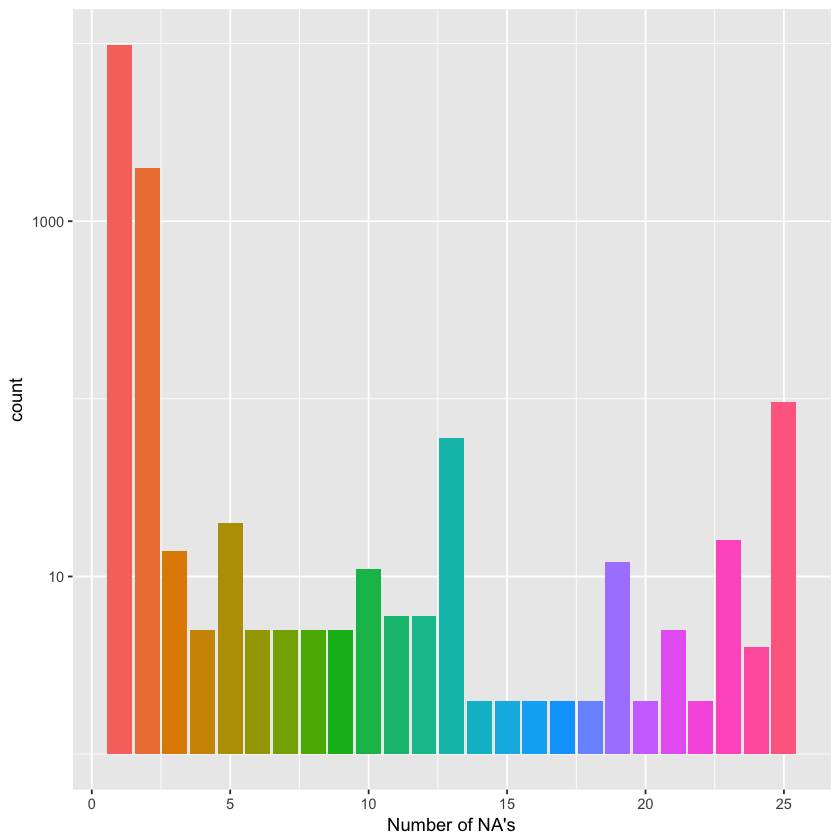

In [32]:
nano = comb %>%
  is.na() %>%
  rowSums() %>%
  as.integer()

comb = comb %>%
  mutate(nano = nano)

plot.nas = comb %>%
  ggplot(aes(nano, fill = as.factor(nano))) +
  geom_bar() +
  scale_y_log10() +
  theme(legend.position = "none") +
  labs(x = "Number of NA's")
plot.nas

Note that at least every row has (1) NA and (2) NA's is the highest frequence after (1). We can see the max number of NA's per ID is 25 and its about 500 the count.

Now we try to know if "comb" it's an unbalanced dataset with the "Target" variable

Target,percentage
0,65.40014
1,34.59986


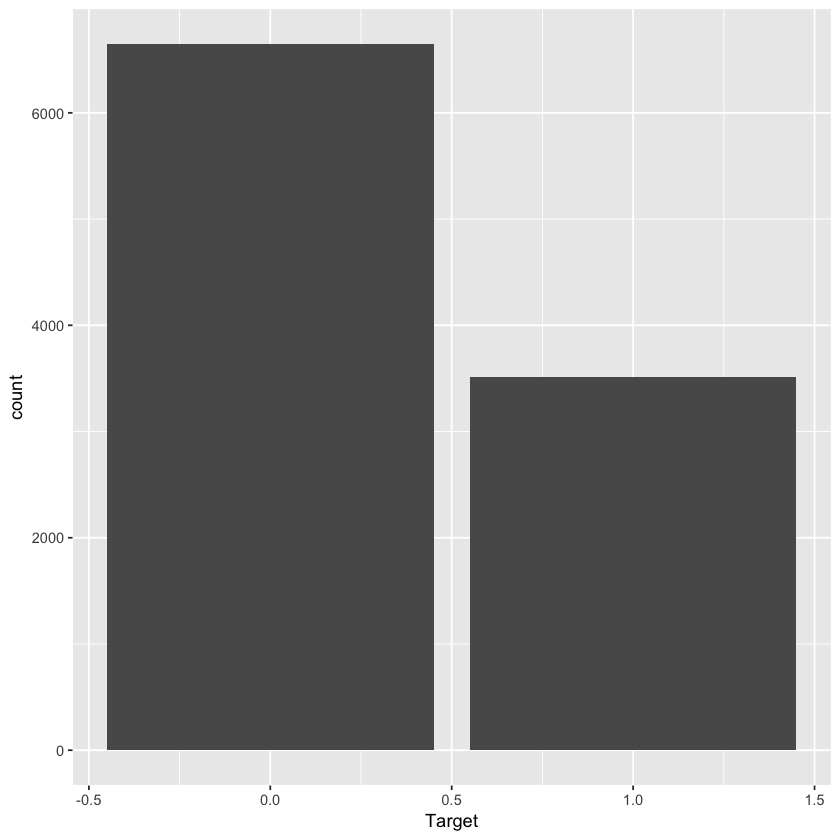

In [8]:
dtrain %>%
  ggplot(aes(Target, fill = Target)) +
  geom_bar() +
  theme(legend.position = "none")

dtrain %>%
  group_by(Target) %>%
  summarise(percentage = n()/nrow(dtrain)*100)

Note that it's not a very unproportional data base with the "Target" variable so in principle we do not need any additional technique (ROSE or SPOTE) oversampling.
After all this little analysis we need to make some exploring about the feature variables in the dataset, so a good way to make this is with correlation between features due to the numeric information that is presented.

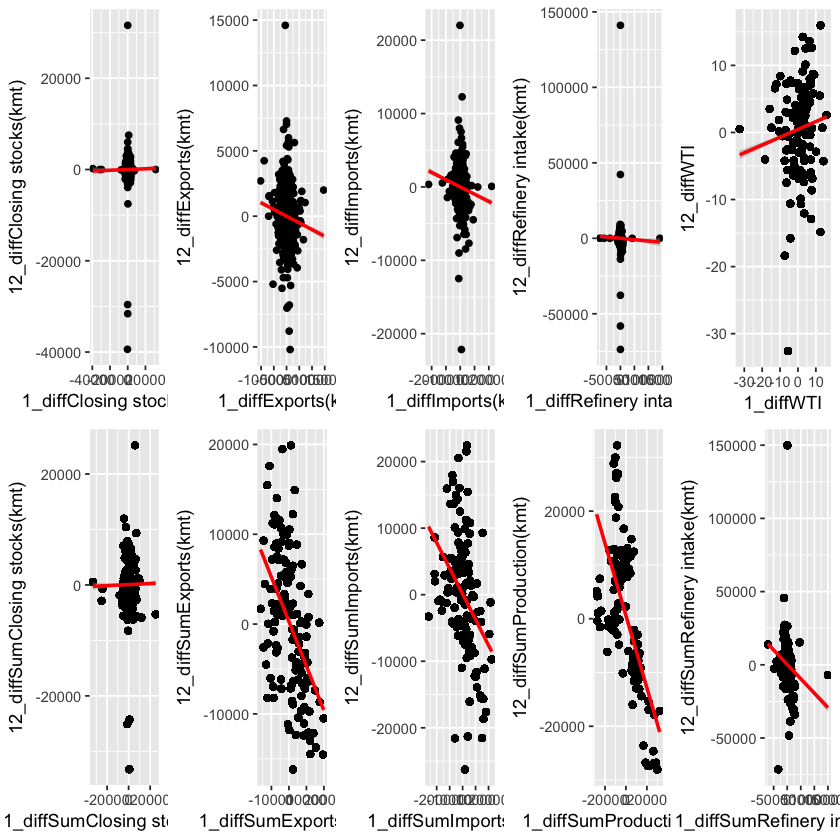

In [9]:
#diffClosing stocks(kmt)
p11 <- dtrain %>%
  ggplot(aes(`1_diffClosing stocks(kmt)`, `12_diffClosing stocks(kmt)`)) +
  geom_point() +
  geom_smooth(method = 'gam', color = "red")

#diffExports(kmt)
p21 <- dtrain %>%
  ggplot(aes(`1_diffExports(kmt)`, `12_diffExports(kmt)`)) +
  geom_point() +
  geom_smooth(method = 'gam', color = "red")

#diffImports(kmt)
p31 <- dtrain %>%
  ggplot(aes(`1_diffImports(kmt)`, `12_diffImports(kmt)`)) +
  geom_point() +
  geom_smooth(method = 'gam', color = "red")

#diffRefinery intake(kmt) 
p41 <- dtrain %>%
  ggplot(aes(`1_diffRefinery intake(kmt)`, `12_diffRefinery intake(kmt)`)) +
  geom_point() +
  geom_smooth(method = 'gam', color = "red")

#`1_diffWTI`
p51 <- dtrain %>%
  ggplot(aes(`1_diffWTI`, `12_diffWTI`)) +
  geom_point() +
  geom_smooth(method = 'gam', color = "red")

#`1_diffSumClosing stocks(kmt)`
p61 <- dtrain %>%
  ggplot(aes(`1_diffSumClosing stocks(kmt)`, `12_diffSumClosing stocks(kmt)`)) +
  geom_point() +
  geom_smooth(method = 'gam', color = "red")

#`1_diffSumExports(kmt)`
p71 <- dtrain %>%
  ggplot(aes(`1_diffSumExports(kmt)`, `12_diffSumExports(kmt)`)) +
  geom_point() +
  geom_smooth(method = 'gam', color = "red")

#$`1_diffSumImports(kmt)`
p81 <- dtrain %>%
  ggplot(aes(`1_diffSumImports(kmt)`, `12_diffSumImports(kmt)`)) +
  geom_point() +
  geom_smooth(method = 'gam', color = "red")

#`1_diffSumProduction(kmt)`
p91 <- dtrain %>%
  ggplot(aes(`1_diffSumProduction(kmt)`, `12_diffSumProduction(kmt)`)) +
  geom_point() +
  geom_smooth(method = 'gam', color = "red")

#`1_diffSumRefinery intake(kmt)`
p101 <- dtrain %>%
  ggplot(aes(`1_diffSumRefinery intake(kmt)`, `12_diffSumRefinery intake(kmt)`)) +
  geom_point() +
  geom_smooth(method = 'gam', color = "red")

suppressWarnings(
grid.arrange(p11,p21,p31,p41,p51,p61,p71,p81,p91,p101,ncol=5))



We can visualize a little correlation between the data in periods in every feature.
In the next code we can see the explicit correlation between all features

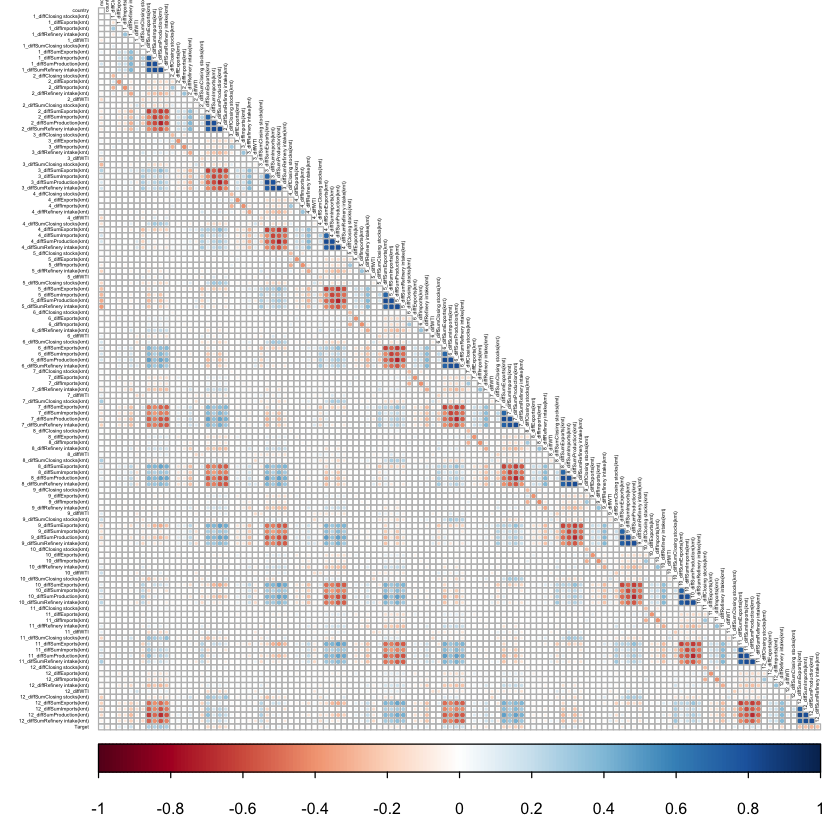

In [10]:
dtrain %>% select(-ID) %>%
  mutate(Target = as.integer(Target)) %>%
  cor(use="complete.obs", method = "spearman") %>%
  corrplot(tl.cex = 0.25, tl.col = 'black', type="lower",  diag=FALSE)

We can see the strongest correlations between some variables in the diferent periods, the difference in refinery intake with "diff sum production", "diff sum exports" and "diff in sum imports"
and strong inverse relationships like "exportations" and "importations".

## Preprocessing <a class="anchor" id="second-bullet"></a>

Now that we have the relationship between all the features the next step is deal with the missing data that could be an issue in the construction of the models.

To deal with this the first thing that we need to do it's a quick column names preprocesing so we don't have any kind of problems using the variables in some functions of libraries in R.

In [4]:
#kill ID 
train = dtrain[,-1]

#preprocessing the name of variables
s = colnames(train)
ss = str_replace_all(s,"_diff","dd")
ss = str_replace_all(ss, " ",".")
ss = str_replace_all(ss, "´(kmt)´","ktm")
ss = str_replace_all(ss, "\\s*\\([^\\)]+\\)","")
ss = str_sub(ss, 3, str_length(ss))

ss = ss[-c(1:2)] #with out mounth and country

sec = c(rep(1,10),rep(2,10),rep(3,10),rep(4,10),rep(5,10),rep(6,10),rep(7,10),rep(8,10)
        ,rep(9,10),rep(10,10),rep(11,10),rep(12,10))

sec = as.character(sec)
sec = c(sec,"1n")

sss = paste(ss, sec, sep="")
sss = c(s[c(1:2)],sss)
sss[123] = "Target"

colnames(train) = sss #rename columns

#change levels of Target for a future use in some with some libraries
train$Target = as.factor(train$Target)
levels(train$Target) <- c('down', 'up')


Now that we made the variables name preprocessing we'll make the imputation of the missing values in "diffClosing stocks(kmt)" and "diffImports(kmt)" in this case with the mean.

In [5]:
#imports
train$dImports1 <- with(train, Hmisc::impute(dImports1, mean)); train$dImports1 = as.numeric(train$dImports1)
train$dImports2 <- with(train, Hmisc::impute(dImports2, mean)); train$dImports2 = as.numeric(train$dImports2)
train$dImports3 <- with(train, Hmisc::impute(dImports3, mean)); train$dImports3 = as.numeric(train$dImports3)
train$dImports4 <- with(train, Hmisc::impute(dImports4, mean)); train$dImports4 = as.numeric(train$dImports4)
train$dImports5 <- with(train, Hmisc::impute(dImports5, mean)); train$dImports5 = as.numeric(train$dImports5)
train$dImports6 <- with(train, Hmisc::impute(dImports6, mean)); train$dImports6 = as.numeric(train$dImports6)
train$dImports7 <- with(train, Hmisc::impute(dImports7, mean)); train$dImports7 = as.numeric(train$dImports7)
train$dImports8 <- with(train, Hmisc::impute(dImports8, mean)); train$dImports8 = as.numeric(train$dImports8)
train$dImports9 <- with(train, Hmisc::impute(dImports9, mean)); train$dImports9 = as.numeric(train$dImports9)
train$ddImports10 <- with(train, Hmisc::impute(ddImports10, mean)); train$ddImports10 = as.numeric(train$ddImports10)
train$ddImports11 <- with(train, Hmisc::impute(ddImports11, mean)); train$ddImports11 = as.numeric(train$ddImports11)
train$ddImports12 <- with(train, Hmisc::impute(ddImports12, mean)); train$ddImports12 = as.numeric(train$ddImports12)

#ddClosing.stocks
train$dClosing.stocks1 <- with(train, Hmisc::impute(dClosing.stocks1, mean)); train$dClosing.stocks1 = as.numeric(train$dClosing.stocks1)
train$dClosing.stocks2 <- with(train, Hmisc::impute(dClosing.stocks2, mean)); train$dClosing.stocks2 = as.numeric(train$dClosing.stocks2)
train$dClosing.stocks3 <- with(train, Hmisc::impute(dClosing.stocks3, mean)); train$dClosing.stocks3 = as.numeric(train$dClosing.stocks3)
train$dClosing.stocks4 <- with(train, Hmisc::impute(dClosing.stocks4, mean)); train$dClosing.stocks4 = as.numeric(train$dClosing.stocks4)
train$dClosing.stocks5 <- with(train, Hmisc::impute(dClosing.stocks5, mean)); train$dClosing.stocks5 = as.numeric(train$dClosing.stocks5)
train$dClosing.stocks6 <- with(train, Hmisc::impute(dClosing.stocks6, mean)); train$dClosing.stocks6 = as.numeric(train$dClosing.stocks6)
train$dClosing.stocks7 <- with(train, Hmisc::impute(dClosing.stocks7, mean)); train$dClosing.stocks7 = as.numeric(train$dClosing.stocks7)
train$dClosing.stocks8 <- with(train, Hmisc::impute(dClosing.stocks8, mean)); train$dClosing.stocks8 = as.numeric(train$dClosing.stocks8)
train$dClosing.stocks9 <- with(train, Hmisc::impute(dClosing.stocks9, mean)); train$dClosing.stocks9 = as.numeric(train$dClosing.stocks9)
train$ddClosing.stocks10 <- with(train, Hmisc::impute(ddClosing.stocks10, mean)); train$ddClosing.stocks10 = as.numeric(train$ddClosing.stocks10)
train$ddClosing.stocks11 <- with(train, Hmisc::impute(ddClosing.stocks11, mean)); train$ddClosing.stocks11 = as.numeric(train$ddClosing.stocks11)
train$ddClosing.stocks12 <- with(train, Hmisc::impute(ddClosing.stocks12, mean)); train$ddClosing.stocks12 = as.numeric(train$ddClosing.stocks12)

So once we make this little preprocessing we preceed to make the models.
In this time we will use h2o extention of R.

## Modelling preparation <a class="anchor" id="3-bullet"></a>


H2o is a powerfull tool that many companies are using everyday as extention of programming languages like R and Python, it's a good way to make machine learning and statistics in general. Easy to implement and fast.

The first thing we need its to initialize the h2o, this time with my localhost :)

In [6]:
h2o.init(max_mem_size = "10G",enable_assertions = F)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/p_/f8jv3v1d4lx7vx5psd1f1lv00000gn/T//Rtmp74eBRP/h2o_miguelangelalbaacosta_started_from_r.out
    /var/folders/p_/f8jv3v1d4lx7vx5psd1f1lv00000gn/T//Rtmp74eBRP/h2o_miguelangelalbaacosta_started_from_r.err


Starting H2O JVM and connecting: ............ Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         11 seconds 643 milliseconds 
    H2O cluster version:        3.14.0.7 
    H2O cluster version age:    2 months and 11 days  
    H2O cluster name:           H2O_started_from_R_miguelangelalbaacosta_lfx032 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   8.89 GB 
    H2O cluster total cores:    0 
    H2O cluster allowed cores:  0 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:  

Next we need is make a data partition or split to make the validation dataset for the models, "train" (80%) and "valid" (20%) so then we can put all our data in the h2o enviroment.

In [7]:
set.seed(1234)
trainIndex <- createDataPartition(train$Target, p = 0.8, list = FALSE, times = 1)

Train <- train[trainIndex,] #not overwrite
valid <- train[-trainIndex,]

train = Train

train = as.h2o(train)
test = as.h2o(test)
valid = as.h2o(valid)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Identify predictors and response:

In [8]:
y <- "Target"
## the response variable is an integer, we will turn it into a categorical/factor for binary classification
train[[y]] <- as.factor(train[[y]]) 
x <- setdiff(names(train), y)

For binary classification, response should be a factor

In [9]:
train[,y] <- as.factor(train[,y])
valid[,y] <- as.factor(valid[,y])

Number of CV folds (to generate level-one data for stacking)

In [17]:
nfolds <- 5

We proceed to make our first model, this time "Gradient Boosting Machine" as the simplest way possible just to make a first look 

In [18]:
simple_gbm = h2o.gbm(x = x, y = y, 
                     training_frame = train,
                     validation_frame = valid,
                     keep_cross_validation_predictions = TRUE,
                     nfolds = 5 , seed = 1)
# This gives you an idea of the variance between the folds
simple_gbm@model$cross_validation_metrics_summary
h2o.auc(h2o.performance(simple_gbm,newdata = valid))

  |======================================================================| 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.72319955,0.013387299,0.7219917,0.71714115,0.7560827,0.69726443,0.72351766
auc,0.78203905,0.0041616824,0.7750007,0.7835878,0.7920903,0.7775416,0.78197485
err,0.27680048,0.013387299,0.2780083,0.28285888,0.24391727,0.30273557,0.27648234
err_count,450.0,25.65151,469.0,467.0,401.0,498.0,415.0
f0point5,0.60468656,0.015064604,0.60919183,0.59149444,0.64115644,0.57739556,0.6041944
f1,0.6349049,0.0066977832,0.6274821,0.6284805,0.65281385,0.62946427,0.63628393
f2,0.6692073,0.010187816,0.6469047,0.67040056,0.664903,0.6918548,0.67197335
lift_top_group,2.6521015,0.11233806,2.4891796,2.587504,2.9357142,2.54198,2.7061298
logloss,0.52311844,0.004649132,0.5310932,0.5202394,0.5122172,0.5280913,0.523951
max_per_class_error,0.31849194,0.011142072,0.33946487,0.29840142,0.3267857,0.32588455,0.30192307


[1] 0.7932361

As we can see the AUC just for the simple model is about 79.32%, so we are going to implement different parameters and try more models as follows:

In [19]:
#GBM with more parameters specification
my_gbm = h2o.gbm(x = x,
                  y = y,
                  training_frame = train,
                  ntrees = 100,
                  distribution = "bernoulli",
                  learn_rate = 0.2,
                  nfolds = nfolds,
                  fold_assignment = "AUTO",
                  keep_cross_validation_predictions = TRUE,
                  ignore_const_cols = TRUE,
                  seed = 1)

# Train & Cross-validate a RF
my_rf = h2o.randomForest(x = x,
                          y = y,
                          training_frame = train,
                          validation_frame = valid,
                          nfolds = nfolds,
                          fold_assignment = "AUTO",
                          keep_cross_validation_predictions = TRUE,
                          ignore_const_cols = TRUE,
                          seed = 1)

# Train & Cross-validate a DNNº
my_dl = h2o.deeplearning(x = x,
                          y = y,
                          training_frame = train,
                          l1 = 0.001,
                          l2 = 0.001,
                          hidden = c(200, 200, 200),
                          nfolds = nfolds,
                          fold_assignment = "AUTO",
                          keep_cross_validation_predictions = TRUE,
                          ignore_const_cols = TRUE,
                          seed = 1)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Some XGBoost models

In [20]:
######################
#####XGBoost models #
######################

# Train & Cross-validate a (shallow) XGB-GBM
my_xgb1 = h2o.xgboost(x = x,
                       y = y,
                       training_frame = train,
                       distribution = "bernoulli",
                       ntrees = 50,
                       max_depth = 3,
                       min_rows = 2,
                       learn_rate = 0.2,
                       nfolds = nfolds,
                       fold_assignment = "AUTO",
                       keep_cross_validation_predictions = TRUE,
                       ignore_const_cols = TRUE,
                       seed = 1)


# Train & Cross-validate another (deeper) XGB-GBM
my_xgb2 = h2o.xgboost(x = x,
                       y = y,
                       training_frame = train,
                       distribution = "bernoulli",
                       ntrees = 50,
                       max_depth = 8,
                       min_rows = 1,
                       learn_rate = 0.1,
                       sample_rate = 0.7,
                       col_sample_rate = 0.9,
                       nfolds = nfolds,
                       fold_assignment = "AUTO",
                       keep_cross_validation_predictions = TRUE,
                       ignore_const_cols = TRUE,
                       seed = 1)

# more complex XGB model, with more specificatios
xgb = h2o.xgboost(x = x
                   ,y = y
                   ,training_frame = train
                   ,validation_frame = valid
                   ,stopping_rounds = 3
                   ,stopping_metric = "AUC"
                   ,distribution = "bernoulli"
                   ,score_tree_interval = 1
                   ,learn_rate=0.1
                   ,nfolds = nfolds
                   ,ntrees=50
                   ,subsample = 0.75
                   ,colsample_bytree = 0.75
                   ,tree_method = "hist"
                   ,grow_policy = "lossguide"
                   ,booster = "gbtree"
                   ,gamma = 0.0
                   ,keep_cross_validation_predictions = TRUE
                   ,ignore_const_cols = TRUE
                   ,seed = 1)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


These models tried to make a aproximation to fit the data, so the next step is to make an ensembled model to increase AUC as follows:

In [21]:
# Train a stacked ensemble using the H2O and XGBoost models from above
base_models = list(my_gbm@model_id, my_rf@model_id, my_dl@model_id,  
                    my_xgb1@model_id, my_xgb2@model_id, xgb@model_id, simple_gbm@model_id)

ensemble = h2o.stackedEnsemble(x = x,
                                y = y,
                                training_frame = train,
                                base_models = base_models)

  |======================================================================| 100%


Now we want to evaluate the performance of the aproximation we made

In [22]:
# Eval ensemble performance on a test set
perf = h2o.performance(ensemble, newdata = valid)

# Compare to base learner performance on the test set
get_auc = function(mm) h2o.auc(h2o.performance(h2o.getModel(mm), newdata = valid))
baselearner_aucs = sapply(base_models, get_auc)
baselearner_best_auc_test = max(baselearner_aucs)
ensemble_auc_test = h2o.auc(perf)

print(sprintf("Best Base-learner Test AUC:  %s", baselearner_best_auc_test))
print(sprintf("Ensemble Test AUC:  %s", ensemble_auc_test))

[1] "Best Base-learner Test AUC:  0.798284353630739"
[1] "Ensemble Test AUC:  0.803481529246431"


Now we see an aproximation of the distinct models, but to find a real answer it's necessary to make a deep research into the data and try to move all hyperparameters of the models.

## Hyperparameter research <a class="anchor" id="4-bullet"></a>

Hyperparameter optimization could give us a better way to aproach the data, finding the best fit possible in this journey of search the best AUC, so the first thing in the next code is the elaboration of a grid trying different parameters.

First we need to know what is the max depth that the model will make and some generic parameters just to start with the first grid.

In [23]:
grid = h2o.grid(
  hyper_params = list( max_depth = c(4,6,8,12,16,20)) ,
  search_criteria = list(strategy = "Cartesian"),
  algorithm="gbm",   # algorithm GBM because in the first models was quite better
  grid_id="first_grid",
  x = x, 
  y = y, 
  training_frame = train, 
  validation_frame = valid,
  ntrees = 10000,    # large number of trees                                                                                                   
  learn_rate_annealing = 0.99,  
  learn_rate = 0.05,   
  sample_rate = 0.8,                                                       
  col_sample_rate = 0.8, 
  stopping_rounds = 5, #convergence criterion, stop once the validation AUC doesn't get better 
  stopping_tolerance = 1e-4,
  stopping_metric = "AUC", 
  score_tree_interval = 10,
  seed = 1  
)

  |======================================================================| 100%


We want now the best sorted AUC's.

In [24]:
grid1 = h2o.getGrid("first_grid", sort_by="auc", decreasing = TRUE);grid1

H2O Grid Details

Grid ID: first_grid 
Used hyper parameters: 
  -  max_depth 
Number of models: 6 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  max_depth          model_ids                auc
1         8 first_grid_model_2 0.8055520445937376
2        16 first_grid_model_4 0.8054417170816981
3        12 first_grid_model_3 0.8050662821984952
4        20 first_grid_model_5 0.8036411292395756
5         6 first_grid_model_1 0.8023129145315258
6         4 first_grid_model_0 0.7955363416682376

With this first aproximation we can see that compared to the first models we don't have a considerable improve with this hyperparameter optimization so with the depth of the last grid we will try to find a better one using more specifications.

In [10]:
#FINAL GRIP
hyper.params = list( 
  max_depth = seq(6,20,1),  #Range of depth established above: the minimum depth and maximum  (6 and 20)                                  
  sample_rate = seq(0.2,1,0.01),       #Row sampling rates per tree                                     
  col_sample_rate = seq(0.2,1,0.01),   #Space of column sampling rates per split                                     
  col_sample_rate_per_tree = seq(0.2,1,0.01),  #Space of column sampling rates per tree
  
  ## search a large space of how column sampling per split should change as a function of the depth of the split
  col_sample_rate_change_per_level = seq(0.9,1.1,0.01),                      
  
  ## search a large space of the number of min rows in a terminal node
  min_rows = 2^seq(0,log2(nrow(train))-1,1),                                 
  
  ## search a large space of the number of bins for split-finding for continuous and integer columns
  nbins = 2^seq(4,10,1),                                                     
  
  ## search a large space of the number of bins for split-finding for categorical columns
  nbins_cats = 2^seq(4,12,1),                                                
  
  ## search a few minimum required relative error improvement thresholds for a split to happen
  min_split_improvement = c(0,1e-8,1e-6,1e-4),                               
  
  ## try all histogram types (QuantilesGlobal and RoundRobin are good for numeric columns with outliers)
  histogram_type = c("UniformAdaptive","QuantilesGlobal","RoundRobin")       
)

criteria = list(
  # Random grid search
  strategy = "RandomDiscrete",      
  # limit the runtime 
  max_runtime_secs = 3600,         
  #100 models
  max_models = 100,                  
  seed = 1234,                        
  stopping_rounds = 5,                
  stopping_metric = "AUC",
  stopping_tolerance = 1e-3
)

grid = h2o.grid(x = x, 
                  y = y, 
                  training_frame = train, 
                  validation_frame = valid,
                  hyper_params = hyper.params,
                  search_criteria = criteria,
                  algorithm = "gbm",
                  grid_id = "final_grid", 
                  ntrees = 10000,                                                            
                  learn_rate = 0.05,                                                         
                  learn_rate_annealing = 0.99,                                               
                  max_runtime_secs = 500,                                                 
                  stopping_rounds = 5, 
                  stopping_tolerance = 1e-4,
                  stopping_metric = "AUC", 
                  score_tree_interval = 10,                                             
                  seed = 1                                                           
)

## grid models by AUC
fGrid = h2o.getGrid("final_grid", sort_by = "auc", decreasing = TRUE)    
fGrid

  |======================================================================| 100%


H2O Grid Details

Grid ID: final_grid 
Used hyper parameters: 
  -  col_sample_rate 
  -  col_sample_rate_change_per_level 
  -  col_sample_rate_per_tree 
  -  histogram_type 
  -  max_depth 
  -  min_rows 
  -  min_split_improvement 
  -  nbins 
  -  nbins_cats 
  -  sample_rate 
Number of models: 44 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  col_sample_rate col_sample_rate_change_per_level col_sample_rate_per_tree
1            0.47                             0.98                     0.68
2            0.35                             1.09                     0.83
3             0.8                              0.9                     0.57
4            0.87                              0.9                      0.7
5            0.71                              0.9                     0.37
   histogram_type max_depth min_rows min_split_improvement nbins nbins_cats
1 UniformAdaptive        14     64.0                1.0E-8   128        128
2

these are all the models sorted by AUC that the final grid made, the next step is extract the best models

In [11]:
for (i in 1:5) {
  gbm <- h2o.getModel(fGrid@model_ids[[i]])
  print(h2o.auc(h2o.performance(gbm, valid = TRUE)))
}

[1] 0.8073708
[1] 0.8068015
[1] 0.8059055
[1] 0.8040674
[1] 0.8040241


In [12]:
# best model after the grid hyperparameter research
gbmxxx <- h2o.getModel(fGrid@model_ids[[1]])

#model parameters
gbmxxx@parameters
model <- do.call(h2o.gbm,
                 #update parameters in place
                 {
                   p <- gbmxxx@parameters
                   p$model_id = NULL          
                   p$training_frame = train  #use the full dataset
                   p$validation_frame = NULL  #no validation frame
                   p$nfolds = 5               #cross-validation
                   p
                 }
)
model@model$cross_validation_metrics_summary

$model_id
[1] "final_grid_model_2"

$training_frame
[1] "RTMP_sid_958a_5"

$validation_frame
[1] "RTMP_sid_958a_6"

$score_tree_interval
[1] 10

$ntrees
[1] 10000

$max_depth
[1] 14

$min_rows
[1] 64

$nbins
[1] 128

$nbins_cats
[1] 128

$stopping_rounds
[1] 5

$stopping_metric
[1] "AUC"

$stopping_tolerance
[1] 1e-04

$max_runtime_secs
[1] 500

$seed
[1] 1

$learn_rate
[1] 0.05

$learn_rate_annealing
[1] 0.99

$distribution
[1] "bernoulli"

$sample_rate
[1] 0.87

$col_sample_rate
[1] 0.47

$col_sample_rate_change_per_level
[1] 0.98

$col_sample_rate_per_tree
[1] 0.68

$min_split_improvement
[1] 1e-08

$histogram_type
[1] "UniformAdaptive"

$x
  [1] "month"                  "country"                "dClosing.stocks1"      
  [4] "dExports1"              "dImports1"              "dRefinery.intake1"     
  [7] "dWTI1"                  "dSumClosing.stocks1"    "dSumExports1"          
 [10] "dSumImports1"           "dSumProduction1"        "dSumRefinery.intake1"  
 [13] "dClosing.stocks2"       "dExports2"              "dImports2"             
 [16] "dRefinery.intake2"      "dWTI2"                  "dSumClosing.stocks2"   
 [19] "dSumExports2"           "dSumImports2"           "dSumProduction2"       
 [22] "dSumRefinery.intake2"   "dClosing.stocks3"       "dExports3"             
 [25] "dImports3"              "dRefinery.intake3"      "dWTI3"                 
 [28] "dSumClosing.stocks3"    "dSumExports3"           "dSumImports3"          
 [31] "dSumProduction3"        "dSumRefinery.intake3"   "dClosing.stocks4"      
 [34] "dExports4"              "dImports4"              "dRefinery.intake4"     
 [37] "dWTI4"                  "dSumClosing.stocks4"    "dSumExports4"          
 [40] "dSumImports4"           "dSumProduction4"        "dSumRefinery.intake4"  
 [43] "dClosing.stocks5"       "dExports5"              "dImports5"             
 [46] "dRefinery.intake5"      "dWTI5"                  "dSumClosing.stocks5"   
 [49] "dSumExports5"           "dSumImports5"           "dSumProduction5"       
 [52] "dSumRefinery.intake5"   "dClosing.stocks6"       "dExports6"             
 [55] "dImports6"              "dRefinery.intake6"      "dWTI6"                 
 [58] "dSumClosing.stocks6"    "dSumExports6"           "dSumImports6"          
 [61] "dSumProduction6"        "dSumRefinery.intake6"   "dClosing.stocks7"      
 [64] "dExports7"              "dImports7"              "dRefinery.intake7"     
 [67] "dWTI7"                  "dSumClosing.stocks7"    "dSumExports7"          
 [70] "dSumImports7"           "dSumProduction7"        "dSumRefinery.intake7"  
 [73] "dClosing.stocks8"       "dExports8"              "dImports8"             
 [76] "dRefinery.intake8"      "dWTI8"                  "dSumClosing.stocks8"   
 [79] "dSumExports8"           "dSumImports8"           "dSumProduction8"       
 [82] "dSumRefinery.intake8"   "dClosing.stocks9"       "dExports9"             
 [85] "dImports9"              "dRefinery.intake9"      "dWTI9"                 
 [88] "dSumClosing.stocks9"    "dSumExports9"           "dSumImports9"          
 [91] "dSumProduction9"        "dSumRefinery.intake9"   "ddClosing.stocks10"    
 [94] "ddExports10"            "ddImports10"            "ddRefinery.intake10"   
 [97] "ddWTI10"                "ddSumClosing.stocks10"  "ddSumExports10"        
[100] "ddSumImports10"         "ddSumProduction10"      "ddSumRefinery.intake10"
[103] "ddClosing.stocks11"     "ddExports11"            "ddImports11"           
[106] "ddRefinery.intake11"    "ddWTI11"                "ddSumClosing.stocks11" 
[109] "ddSumExports11"         "ddSumImports11"         "ddSumProduction11"     
[112] "ddSumRefinery.intake11" "ddClosing.stocks12"     "ddExports12"           
[115] "ddImports12"            "ddRefinery.intake12"    "ddWTI12"               
[118] "ddSumClosing.stocks12"  "ddSumExports12"         "ddSumImports12"        
[121] "ddSumProduction12"      "ddSumRefinery.intake12"

$y
[1] "Target"

  |======================================================================| 100%


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.7314154,0.0117262155,0.69887376,0.74318594,0.7347932,0.73738605,0.7428381
auc,0.7854476,0.0039423597,0.7782907,0.78920287,0.7895616,0.7790532,0.7911295
err,0.2685846,0.0117262155,0.30112627,0.25681406,0.2652068,0.26261398,0.2571619
err_count,437.2,27.994286,508.0,424.0,436.0,432.0,386.0
f0point5,0.61444944,0.010747767,0.5858346,0.62357163,0.61259305,0.62182313,0.62842464
f1,0.6417906,0.0060837055,0.63662374,0.64309764,0.6443719,0.6295026,0.6553571
f2,0.67252904,0.01452815,0.69705516,0.663886,0.6796284,0.6373741,0.6847015
lift_top_group,2.8223474,0.08692255,2.8210702,2.587504,2.9357142,2.8809106,2.8865385
logloss,0.5179362,0.0043132184,0.5256321,0.5119352,0.51259357,0.5250329,0.51448756
max_per_class_error,0.31872416,0.016510213,0.32598713,0.32149202,0.29464287,0.35726795,0.29423076


So the best model was 'final_grid_model_2' with an AUC of 0.8073708.

With next code we can stract the parameters of the Top 5 models and their cross validations if we want to.

In [ ]:
###########
#top models 
########## 

for (i in 1:5) {
  gbm <- h2o.getModel(fGrid@model_ids[[i]])
  cvgbm <- do.call(h2o.gbm,
                   ## update parameters in place
                   {
                     p <- gbmxxx@parameters
                     p$model_id = NULL          
                     p$training_frame = train      ## use the full dataset
                     p$validation_frame = NULL  ## no validation frame
                     p$nfolds = 5               ## cross-validation
                     p
                   }
  )
  print(gbm@model_id)
  print(cvgbm@model$cross_validation_metrics_summary[2,]) ## Pick out the "AUC" row
}


The next step is make the predictions with the model and turn off h2o.

In [14]:
h2o.shutdown()

Are you sure you want to shutdown the H2O instance running at http://localhost:54321/ (Y/N)? Y


[1] TRUE

## Some comments  & extra content <a class="anchor" id="5-bullet"></a>

We made a fair-good fit due to the little problems the data has, a good approximation with different kind of models and searched a better way to improve the models with grid. The next steps could be a ensemble of different calibrated models with a first grid research. 

We could try distinct ways to approach the data doing a long preprocessing imputing the NA’s with different forms like searching strong correlations between features in the dataset and make linear models to impute these missing values. All of this knowing the time series behavior that all the features have.

Another way to start doing this is calibrating a first model and try to make a dimensional reduction just to take the relevant variables in our analysis. So I'm a litte bit curious and I made some codes just to explore more the data. 



In [22]:
library(mlbench)
library(nlme)

train <- dtrain[trainIndex,]
valid <- dtrain[-trainIndex,]

#quit the ID 
train = train[,-1]
valid = valid[,-1]

dtrain$Target = as.factor(dtrain$Target)
train$Target = as.factor(train$Target)
valid$Target = as.factor(valid$Target)
#levels
levels(dtrain$Target) <- c('down', 'up')
levels(train$Target) <- c('down', 'up')
levels(valid$Target) <- c('down', 'up')

All correlated features

In [24]:
# calculate correlation matrix
 correlationMatrix <- cor(dtrain[,4:123],use = "complete.obs") 
 # find attributes that are highly corrected (ideally >0.75)
 highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.5)
 # print indexes of highly correlated attributes
 print(highlyCorrelated)

 [1]   9  13  17  18  19  23  27  29  33  37  39  49  57  59  69  73  79  87  89
[20]  97  99 107 108 109 119   7   8  28  38  47  48  43  58  53  67  68  77  78
[39]  88  83  98  93 103 117 118


Now we will rank the features with importance and plot them with an initial Support Vector Machine model (SVM)

ROC curve variable importance

  only 20 most important variables shown (out of 122)

                               Importance
1_diffSumProduction(kmt)           0.6815
12_diffSumProduction(kmt)          0.6694
1_diffSumRefinery intake(kmt)      0.6644
1_diffSumExports(kmt)              0.6565
1_diffSumImports(kmt)              0.6505
12_diffSumRefinery intake(kmt)     0.6489
12_diffSumImports(kmt)             0.6484
12_diffSumExports(kmt)             0.6368
7_diffSumProduction(kmt)           0.6147
7_diffSumRefinery intake(kmt)      0.6098
6_diffSumProduction(kmt)           0.6048
2_diffSumProduction(kmt)           0.6047
7_diffSumExports(kmt)              0.6029
1_diffRefinery intake(kmt)         0.6026
2_diffSumExports(kmt)              0.6003
6_diffSumExports(kmt)              0.5963
12_diffRefinery intake(kmt)        0.5920
6_diffSumRefinery intake(kmt)      0.5898
7_diffSumImports(kmt)              0.5860
6_diffSumImports(kmt)              0.5807


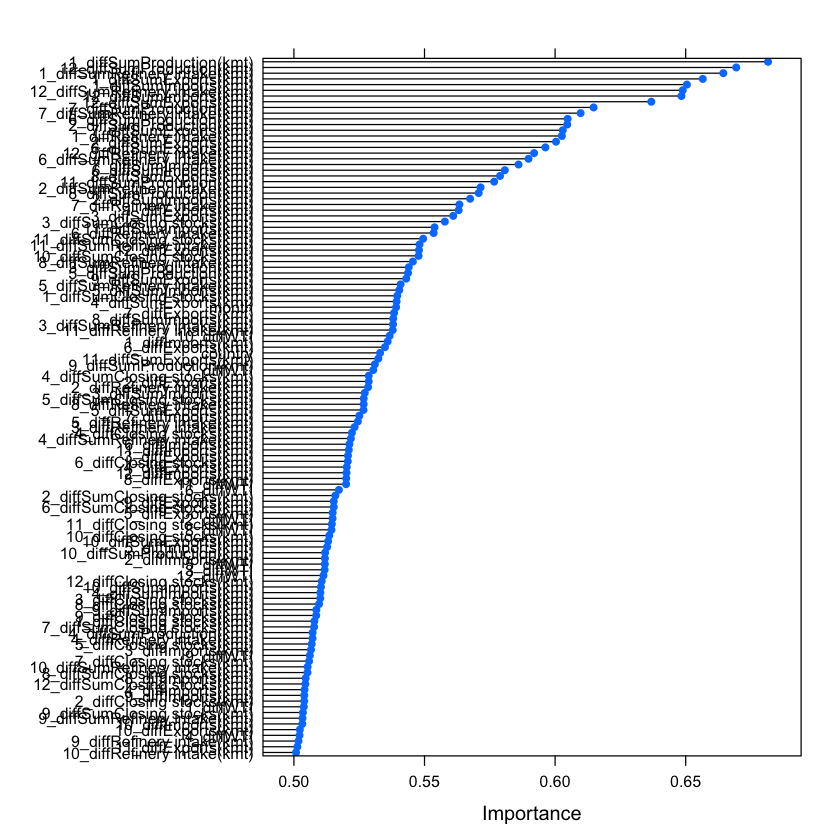

In [26]:
# prepare training scheme
 control <- trainControl(method="repeatedcv",summaryFunction=twoClassSummary, classProbs = TRUE, number=10, repeats=3)
 # train the model
 model <- train(Target~., data=train, method="svmRadial", preProcess="scale", tuneLength = 1, metric = "ROC", trControl=control,na.action=na.exclude)
 # estimate variable importance
 importance <- varImp(model, scale=FALSE)
 # summarize importance
 print(importance)
 # plot importance
 plot(importance)

We can see that we only require 20 variables of the complete dataset

## Additional Python code

Just to approach I made a little code in Python to compare some models and metrics

In [ ]:
# -*- coding: utf-8 -*-
"""
Editor de Spyder

Este es un archivo temporal
"""


import pandas as pd
import sklearn 
import numpy as np

data = pd.read_csv("/Users/miguelangelalbaacosta/Desktop/KAYRROS/Train_1.csv")


from sklearn.cross_validation import train_test_split
train, test = train_test_split(data,
                              train_size=0.8,
                              test_size=0.2)

train_X = train.loc[:,"month":"12_diffSumRefinery intake(kmt)"]
train_Y = train.loc[:,"Target"]

test_X = test.loc[:,"month":"12_diffSumRefinery intake(kmt)"]
test_Y = test.loc[:,"Target"]

 
import xgboost as xgb 


xg_cl = xgb.XGBClassifier(n_estimators=200,seed=123)

xg_cl_1 = xg_cl.fit(train_X,train_Y)

preds = xg_cl_1.predict(test_X)


from sklearn.metrics import confusion_matrix
confusion_matrix(test_Y, preds)
#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________
## xgboost.

import pandas as pd
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import xgboost as xgb 

print(__doc__)

# Loading the Digits dataset
data = pd.read_csv("/Users/miguelangelalbaacosta/Desktop/KAYRROS/trandf.csv")

X = data.loc[:,"month":"12_diffSumRefinery intake(kmt)"]
y = data.loc[:,"Target"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10)

tuned_parameters = [{'max_depth':[5,7,15] , 'learning_rate':[0.03,0.05,0.1],
                     'n_estimators': [50, 100, 500]},
                    {'max_depth':[5,7,15], 'n_estimators': [50, 100, 500]}]

scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(xgb.XGBClassifier(), tuned_parameters, cv=3,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


#___________________________________________________________________________________________________________
#___________________________________________________________________________________________________________

from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()


n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

clf = SVC(C=10,kernel="rbf",gamma=0.001)
clf_1 = clf.fit(X_train,y_train) 

dp = SVC()
dpa = dp.fit(X_train,y_train) 

preds = dpa.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
confusion_matrix(y_test, preds)
accuracy_score(y_test, preds)


(I tried different types of models and techniques like oversampling to improve the metric of all of these models that I will include in the mail in addition of this notebook)